# Area estimation of 2023 land cover change

#### Import functions

In [1]:
# Import strata and sample unit information
import sys 
import math
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mapsource = "../mapLabels2023"
ANNname = "2023"
sampleDict = {}
sampleFull = {}
strata = {}
strataNoAlert = {}
landcoverS = {}
lossyear = {}
with open("sampledpixels_original.csv","r") as sample:
  lines = sample.readlines()[1:]
  for l in lines:
    (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
    sampleDict[ID] = ",".join([Long,Lat,zone,centxUTM,centyUTM])
    sampleFull[ID] = l.strip()
    strata[ID] = int(Stratum)
    if Stratum == "1":
      strataNoAlert[ID] = "1_"+landcover
    landcoverS[ID] = int(landcover)
    lossyear[ID] = int(forestLossYear)+2000
allIDs = sampleDict.keys()

#Strata area
strataAreas = {}
strataCounts = {}
allStrata = []
totalArea = 0
with open("stratatable_nosplit.txt","r") as file:
  lines = file.readlines()[1:]
for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  strataAreas[s] = float(area)
  strataCounts[s] = math.ceil(float(area)/(900/1000000))
  allStrata.append(int(s))
  totalArea += float(area)
Nstrata = len(strataCounts)

with open("stratatable.txt","r") as file:
  lines = file.readlines()[1:]

for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  if int(s)%5 == 1:
    landcover = str(int((int(s)-1)/5)+1)
    strataAreas["1_"+landcover] = float(area)
    strataCounts["1_"+landcover] = math.ceil(float(area)/(900/1000000))

### Functions

In [2]:
def getRefANNconversion(yeslabels,nolabels,only2023):
  with open("reference_conversion.csv","r") as reffile:
    reflist = reffile.readlines()[1:]
  refann = {}
  for line in reflist:
    fields = line.strip().split(",")
    (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
    if conversion in yeslabels:
      if only2023==False or (only2023 and prevyear == "FALSE"):
        refann[ID] = 2
      else:
        refann[ID] = 1
    elif conversion in nolabels:
      refann[ID] = 1
    else:
      refann[ID] = 0
  return refann

In [3]:
def getArea(refANN, IDlist=allIDs, selectedStrata=allStrata, write=True):
  N = strataCounts
  Nstrata = len(selectedStrata)
  maxStrata = max(selectedStrata)
  Ntotal = sum([N[str(s)] for s in selectedStrata])
  n = [[0,0,0] for s in range(maxStrata+1)]
  ntotal = [0 for s in range(maxStrata+1)]

  #confusion matrix
  for ID in IDlist:
      n[strata[ID]][int(refANN[ID])] += 1
      if refANN[ID] >0:
        ntotal[strata[ID]] += 1

  #Area
  y = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if ntotal[s] > 0:
      y += (n[s][2]/ntotal[s])*strataAreas[stringS]

  Asub = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if y > 0:
        if (n[s][2]) > 0:
            yhmean = n[s][2]/ntotal[s]
            if ntotal[s] >1:
              yhsampvar = ((n[s][2])*((1-yhmean)**2) + (n[s][1])*((0-yhmean)**2))/(ntotal[s]-1)
            else:
              yhsampvar = ((n[s][2])*((1-yhmean)**2) + (n[s][1])*((0-yhmean)**2))/(ntotal[s])
            Asub += N[stringS]**2 * (1 - ntotal[s]/N[stringS]) * (yhsampvar)/ntotal[s]
  
  if y > 0:
    areaSE = math.sqrt(Asub/(Ntotal**2))*totalArea
    area = y
    percent = areaSE/area*100
  else:
    areaSE = math.nan
    percent = math.nan
    area = 0

  return [area,areaSE,percent]

In [4]:
def getRefANNchangeType(yeslabels,only2023=False,conversionClasses=["no","natural","human","maybe"],treecoverlossonly=False,naturalvegonly=False,naturallabels=["primary","secondary","scruff"]):
  with open("reference_conversion.csv","r") as reffile:
    reflist = reffile.readlines()[1:]
  with open("referenceTimeSeriesInterpolated16.csv","r") as reffile:
    tslist = reffile.readlines()[1:]
  refann = {}
  refts = {}
  for line in tslist:
    fields = line.strip().split(",")
    refts[fields[0]] = fields
  i=0
  for line in reflist:
    fields = line.strip().split(",")
    (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
    if int(ID) >= 1:
      tsfields = refts[ID]
      countDist = tsfields[5:].count("VLmin") + tsfields[5:].count("VLmaj") + tsfields[5:].count("OCmin") + tsfields[5:].count("OCmaj")
      if treecoverlossonly == False or (lossyear[ID]>=0 and ("Clear cut" in changetype or "tree removal" in changetype or "Plantation clearing" in changetype or "tree" in naturalproportion)):
        if naturalvegonly:
          if " " in naturalproportion and (conversion == "human" or conversion =="maybeh"):
            (prop, cat) = naturalproportion.split(" ")
          elif conversion == "natural" and "land use" in naturalproportion:
            prop = "0"
            cat = "natural"
          elif naturalproportion == "":
            cat = "no"
            prop = 0
          else:
            prop = 100#naturalproportion
            cat = "natural"
        if (not naturalvegonly) or (cat in naturallabels and int(prop) > 0):
          if "Built-up growth" in changetype:
            changetype = "Built-up growth"
          elif "Agriculture expansion" in changetype:
            changetype = "Agriculture expansion"
          elif "Other change" in changetype:
            changetype="Other change"
          elif "Fire" in changetype and (conversion != "natural"):
            changetype="Fire (non-conversion)"
          elif "Shifting cultivation" in changetype:
            changetype="Shfiting cultivation"
          #elif "browning" in changetype or "greening" in changetype:
          #  changetype="browngreen"
          else:
            changetype = changetype.split(";")[0]
          if changetype in yeslabels and conversion in conversionClasses:
            if (only2023==False or (only2023 and prevyear == "FALSE")) and (conversion!="no" or countDist>=10):
              refann[ID] = 2
            else:
              refann[ID] = 1
          else:
            refann[ID] = 1
        else:
          refann[ID] = 1
      else:
        refann[ID] = 1
    else:
      refann[ID] = 0
  return refann

In [5]:
def getAllChangeType(only2023=False,conversionClasses=["no","natural","human"], treecoverlossonly=False,naturalvegonly=False,naturallabels=["primary","secondary","scruff"]):
  with open("reference_conversion.csv","r") as reffile:
    reflist = reffile.readlines()[1:]
  types = {}
  for line in reflist:
    fields = line.strip().split(",")
    (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
    if changetype != "No Change" and conversion in conversionClasses:      
      if (only2023==False or (only2023 and prevyear == "FALSE")) and (treecoverlossonly == False or (lossyear[ID]>=0 and ("Clear cut" in changetype or "tree removal" in changetype or "Plantation clearing" in changetype or "tree" in naturalproportion))):# and "Built-up growth" in changetype:
        if naturalvegonly:
          if " " in naturalproportion and (conversion == "human"):
            (prop, cat) = naturalproportion.split(" ")
          elif conversion == "natural" and "land use" in naturalproportion:
            prop = "0"
            cat = "natural"
          elif naturalproportion == "":
            cat = "no"
            prop = 0
          else:
            prop = 100#naturalproportion
            cat = "natural"
        if (not naturalvegonly) or (cat in naturallabels and int(prop) > 0):
          if "Built-up growth" in changetype:
            changetype = "Built-up growth"
          elif "Agriculture expansion" in changetype:
            changetype = "Agriculture expansion"
          elif "Other change" in changetype:
            changetype="Other change"
          elif "Fire" in changetype and conversion != "natural":
            changetype="Fire (non-conversion)"
          elif "Shifting cultivation" in changetype:
            changetype="Shfiting cultivation"
          #elif "browning" in changetype or "greening" in changetype:
          #  changetype="browngreen"
          else:
            changetype = changetype.split(";")[0]
          if not changetype in types.keys():
            types[changetype] = 1
          else:
            types[changetype]+=1
  return types


In [6]:
# Functions for natural vegetation loss based on proportion

def getAllChangeTypeNatural(naturallabels):
  with open("reference_conversion.csv","r") as reffile:
    reflist = reffile.readlines()[1:]
  types = {}
  for line in reflist:
    fields = line.strip().split(",")
    (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
    if conversion == "human" and prevyear == "FALSE":
      if " " in naturalproportion:
        (prop, cat) = naturalproportion.split(" ")
      else:
        prop = naturalproportion
        cat = "natural"
      if cat in naturallabels and int(prop) > 0:
        if "Built-up growth" in changetype:
          changetype = "Built-up growth"
        elif "Agriculture expansion" in changetype:
          changetype = "Agriculture expansion"
        elif "Other change" in changetype:
          changetype="Other change"
        elif "Fire" in changetype and conversion != "natural":#conversion == "no":
          changetype="Fire (non-conversion)"
        elif "Shifting cultivation" in changetype:
          changetype="Shfiting cultivation"
        else:
          changetype = changetype.split(";")[0]
        if not changetype in types.keys():
          types[changetype] = 1
        else:
          types[changetype]+=1
  return types

def getRefANNchangeTypeNatural(yeslabels,naturallabels):
  with open("reference_conversion.csv","r") as reffile:
    reflist = reffile.readlines()[1:]
  refann = {}
  for line in reflist:
    fields = line.strip().split(",")
    (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
    if "Built-up growth" in changetype:
        changetype = "Built-up growth"
    elif "Agriculture expansion" in changetype:
        changetype = "Agriculture expansion"
    elif "Other change" in changetype:
        changetype="Other change"
    elif "Fire" in changetype and conversion != "natural":#conversion == "no":
        changetype="Fire (non-conversion)"
    elif "Shifting cultivation" in changetype:
        changetype="Shfiting cultivation"
    else:
        changetype = changetype.split(";")[0]
    if conversion == "human" and changetype in yeslabels and prevyear == "FALSE":
      if " " in naturalproportion:
        (prop, cat) = naturalproportion.split(" ")
      else:
        prop = naturalproportion
        cat = "natural"
      if cat in naturallabels and int(prop) > 0:
        #print(ID, conversion)
        refann[ID] = 2
      else:
        refann[ID] = 1
    else:
      refann[ID] = 1
  return refann

### Calculations

In [7]:
only2023 = True
refANN = getRefANNconversion(["human"],["natural","no"],only2023)
(area,areaSE,percent) = getArea(refANN)
print("Human",area,areaSE,percent,area/totalArea*100,sep=",")

refANN = getRefANNconversion(["natural"],["human","no"],only2023)
(area,areaSE,percent) = getArea(refANN)
print("Fire",area,areaSE,percent,area/totalArea*100,sep=",")

refANN = getRefANNconversion(["natural","human"],["no"],only2023)
(area,areaSE,percent) = getArea(refANN)
print("Combined",area,areaSE,percent,area/totalArea*100,sep=",")

Human,286437.5887676272,76319.09713715661,26.644232506464284,0.21688392513026128
Fire,149228.26441912484,42951.422228164585,28.78236398135044,0.11299219444921603
Combined,435665.85318675207,86082.07485381301,19.758738084279734,0.3298761195794774


total area of change 19427516.428586565 2810686.658833546 14.467555177036262


148663.48916394115 42772.974529179715 28.771674047022465
18992697.73828259 2810961.5833159476 14.80022281221292
Natural greening,6500529.764528265,2740869.1248422773,42.163780862884465,4.922050966923668
Natural browning,5538947.166897712,543819.1025765521,9.818095139570318,4.193962837819024
Crop cycle change,2802472.1900535114,270748.2656766104,9.661050933441755,2.121967201519395
Natural browning and greening,1672232.2131902,365892.390713712,21.88047735402017,1.2661756010667276
Fire (non-conversion),1299313.8570412705,267391.7471471935,20.57945781907414,0.9838104366946783
Wetland,740071.2594315707,146602.30199569988,19.80921433272537,0.5603648610232804
Human conversion,286155.20114003535,76267.35903136447,26.652445500734274,0.21667010774217393
Other change,248432.13660887058,106163.5236324,42.73341004974044,0.1881070747315224
Fire conversion,148663.48916394115,42772.974529179715,28.771674047022465,0.11256455967304127
Plantation clearing,90442.26307451766,22446.193560331332,24.818257302

Text(0.5,0,'Megahectares (Mha)')

<Figure size 432x288 with 0 Axes>

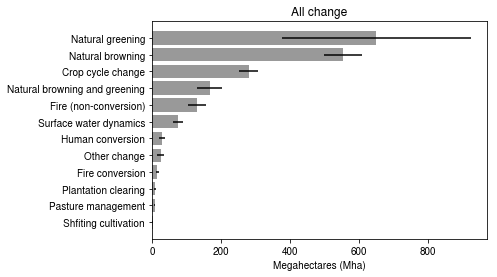

In [8]:
only2023 = True
scale = 10000
changeDict = {}
simple = {}
areas = []
SEs = []
names = []
types = []
typesn = getAllChangeType(only2023,["natural","human","no"])
refANN = getRefANNchangeType(list(typesn.keys()),only2023,["natural","human","no"])
(area,areaSE,percent) = getArea(refANN)
print("total area of change",area,areaSE,percent)

typesh = getAllChangeType(only2023,["human"])
refANN = getRefANNchangeType(list(typesh.keys()),only2023,["human"])
(area,areaSE,percent) = getArea(refANN)
types.append("Human conversion")
changeDict["Human conversion"] = [area,areaSE,percent]
typesn = getAllChangeType(only2023,["natural"])
refANN = getRefANNchangeType(list(typesn.keys()),only2023,["natural"])
(area,areaSE,percent) = getArea(refANN)
types.append("Fire conversion")
changeDict["Fire conversion"] = [area,areaSE,percent]
print(area,areaSE,percent)

typesn = getAllChangeType(only2023,["no"])
refANN = getRefANNchangeType(list(typesn.keys()),only2023,["no"])
(area,areaSE,percent) = getArea(refANN)
print(area,areaSE,percent)
for change in typesn.keys():
  refANN = getRefANNchangeType([change],only2023,["no"])
  (area,areaSE,percent) = getArea(refANN)
  changeDict[change] = [area,areaSE,percent]
  simple[int(area)] = change
  types.append(change)

sortedDict = dict(sorted(changeDict.items(), key=lambda x:x[1], reverse=True))
for k in sortedDict.keys():
  if k == "Wetland":
    names.append("Surface water dynamics")
  else:
    names.append(k)
  areas.append(changeDict[k][0]/scale)
  SEs.append(changeDict[k][1]/scale)
  print(k,changeDict[k][0],changeDict[k][1],changeDict[k][2],changeDict[k][0]/totalArea*100,sep=",")

plt.figure()
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
y_pos = np.arange(len(names))
ax.barh(names,areas,xerr=SEs,color="#999999")
ax.invert_yaxis()
ax.set_title("All change")
ax.set_xlabel("Megahectares (Mha)")

Fire conversion 148663.48916394115 42772.974529179715
totalnaturaltreecoverloss 124880.36406947058 40288.793863718194 32.26191256241506
totalhumanconversionnatural 196045.47507189412 61548.12470986941 31.394820353440128
totalhumanconversion_longlived/secondary 156579.36605389413 59570.246924455154 38.044761851923234
totalhumanconversiontreecoverloss 186817.1360207647 61561.34950234669 32.95273164636468
totalhumanremovaltreecoverloss 330079.1270722235 73206.80604743214 22.178562666706885
Plantation 90442.26307451766 22446.193560331332 24.81825730282462
totaltreecoverloss 454959.491141694 81762.02872073636 17.971276632906232
286155.20114003535 76267.35903136447 26.652445500734274
Fire,148663.48916394115,42772.974529179715,28.771674047022465,124880.36406947058,146654.65608747056,0,0.11256455967304127
Agriculture expansion,130533.87968914118,50879.00219007264,38.97762198690334,105054.85682847058,99481.01288714117,130533.87968914118,0.09883723819651798
Built-up growth,42964.0044204,20384.73

<Figure size 640x480 with 0 Axes>

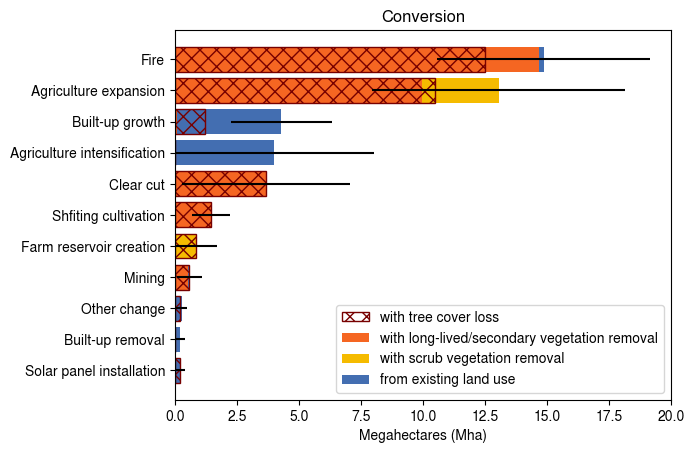

In [9]:
only2023 = True
scale = 10000#000
changeDict = {}
simple = {}
areas = []
SEs = []
names = []
types = []

refANN = getRefANNchangeType(["Fire"],only2023,["natural"],treecoverlossonly=False)
(area,areaSE,percent) = getArea(refANN)
changeDict["Fire"] = [area,areaSE,percent]
print("Fire conversion",area,areaSE)
refANN = getRefANNchangeType(["Fire"],only2023,["natural"],treecoverlossonly=True)
(area,areaSE,percent) = getArea(refANN)
changeDict["Fire"].append(area)
print("totalnaturaltreecoverloss",area,areaSE,percent)
refANN = getRefANNchangeType(["Fire"],only2023,["natural"],treecoverlossonly=False,naturalvegonly=True,naturallabels=["natural"])
(area,areaSE,percent) = getArea(refANN)
changeDict["Fire"].append(area)
changeDict["Fire"].append(0)

typesh = getAllChangeType(only2023,["human"],naturalvegonly=True,naturallabels=["primary","secondary","scruff"])
refANN = getRefANNchangeType(list(typesh.keys()),only2023,["human"],naturalvegonly=True,naturallabels=["primary","secondary","scruff"])
(area,areaSE,percent) = getArea(refANN)
print("totalhumanconversionnatural",area,areaSE,percent)

typesh = getAllChangeType(only2023,["human"],naturalvegonly=True,naturallabels=["primary","secondary"])
refANN = getRefANNchangeType(list(typesh.keys()),only2023,["human"],naturalvegonly=True,naturallabels=["primary","secondary"])
(area,areaSE,percent) = getArea(refANN)
print("totalhumanconversion_longlived/secondary",area,areaSE,percent)

typesh = getAllChangeType(only2023,["human"],treecoverlossonly=True)
refANN = getRefANNchangeType(list(typesh.keys()),only2023,["human"],treecoverlossonly=True)
(area,areaSE,percent) = getArea(refANN)
print("totalhumanconversiontreecoverloss",area,areaSE,percent)

typesh = getAllChangeType(only2023,["human","no"],treecoverlossonly=True)
refANN = getRefANNchangeType(list(typesh.keys()),only2023,["human","no"],treecoverlossonly=True)
(area,areaSE,percent) = getArea(refANN)
print("totalhumanremovaltreecoverloss",area,areaSE,percent)

refANN = getRefANNchangeType(["Plantation clearing"],only2023,["human","natural","no"],treecoverlossonly=True)
(area,areaSE,percent) = getArea(refANN)
print("Plantation",area,areaSE,percent)

typesh = getAllChangeType(only2023,["human","natural","no"],treecoverlossonly=True)
refANN = getRefANNchangeType(list(typesh.keys()),only2023,["human","natural","no"],treecoverlossonly=True)
(area,areaSE,percent) = getArea(refANN)
print("totaltreecoverloss",area,areaSE,percent)


typesh = getAllChangeType(only2023,["human"])
refANN = getRefANNchangeType(list(typesh.keys()),only2023,["human"])
(area,areaSE,percent) = getArea(refANN)
print(area,areaSE,percent)
for change in typesh.keys():
  refANN = getRefANNchangeType([change],only2023,["human"])
  (area,areaSE,percent) = getArea(refANN)
  changeDict[change] = [area,areaSE,percent]
  simple[int(area)] = change
  types.append(change)
  refANN = getRefANNchangeType([change],only2023,["human"],treecoverlossonly=True)
  (area,areaSE,percent) = getArea(refANN)
  changeDict[change].append(area)
  refANN = getRefANNchangeType([change],only2023,["human"],naturalvegonly=True,naturallabels=["primary","secondary"])
  (area,areaSE,percent) = getArea(refANN)
  changeDict[change].append(area)
  refANN = getRefANNchangeType([change],only2023,["human"],naturalvegonly=True,naturallabels=["primary","secondary","scruff"])
  (area,areaSE,percent) = getArea(refANN)
  changeDict[change].append(area)

sortedDict = dict(sorted(changeDict.items(), key=lambda x:x[1], reverse=True))
areas2 = []
areas3 = []
areas4 = []
leftstart = []
for k in sortedDict.keys():
  names.append(k)
  areas.append(changeDict[k][0]/scale)
  SEs.append(changeDict[k][1]/scale)
  areas2.append(changeDict[k][3]/scale)
  areas3.append((changeDict[k][4])/scale)
  areas4.append((changeDict[k][5])/scale)
  print(k,changeDict[k][0],changeDict[k][1],changeDict[k][2],changeDict[k][3],changeDict[k][4],changeDict[k][5],changeDict[k][0]/totalArea*100,sep=",")

plt.style.use('default')
plt.figure()
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
y_pos = np.arange(len(names))

ax.barh(names,areas,xerr=SEs,label="from existing land use",color="#436EB1")
ax.barh(names,areas4, label = "with scrub vegetation removal",color="#F5BB00")
ax.barh(names,areas3, label = "with long-lived/secondary vegetation removal",color="#F56622")
ax.barh(names,areas2, label = "with tree cover loss",color = "#BC384100",hatch='xx',edgecolor="#770000")
ax.invert_yaxis()
ax.set_title("Conversion")
ax.set_xlabel("Megahectares (Mha)")
ax.set_xlim(0,20)
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1],loc = "lower right")

In [10]:
print("Area of conversion of natural vegetation for 2023\n")
categories = ["long-lived","secondary","scrub","long-lived/secondary","any natural vegetation"]
i=0
for naturallabels in [["primary"],["secondary"],["scruff"],["primary","secondary"],["primary","secondary","scruff"]]:
  changeDict = {}
  simple = {}
  types = getAllChangeTypeNatural(naturallabels)
  refANN = getRefANNchangeTypeNatural(list(types.keys()),naturallabels)
  (area,areaSE,percent) = getArea(refANN)
  print(categories[i], "total: ", area,areaSE,percent)

  for change in types.keys():
    refANN = getRefANNchangeTypeNatural([change],naturallabels)
    (area,areaSE,percent) = getArea(refANN)
    changeDict[change] = [area,areaSE,percent]
    simple[int(area)] = change
    print(change,":",int(area),"+-",int(areaSE),"(",percent,"%)","Total percent",round(area/totalArea*100,3))

  sortedareas = sorted(simple.keys(),reverse=True)
  for a in sortedareas:
    k = simple[a]
  i+=1
  print()

Area of conversion of natural vegetation for 2023

long-lived total:  48186.13748094118 34741.37291638013 72.0982729319635
Agriculture expansion : 7158 +- 5527 ( 77.21783275702155 %) Total percent 0.005
Mining : 5149 +- 5149 ( 99.99999156059486 %) Total percent 0.004
Clear cut : 35877 +- 33928 ( 94.56677449614261 %) Total percent 0.027

secondary total:  108393.22857295294 49408.86339478183 45.582979716788955
Clear cut : 757 +- 757 ( 99.99994189585179 %) Total percent 0.001
Built-up growth : 757 +- 757 ( 99.99994189585179 %) Total percent 0.001
Agriculture expansion : 92322 +- 48816 ( 52.87639579025986 %) Total percent 0.07
Shfiting cultivation : 14555 +- 7595 ( 52.18005613344704 %) Total percent 0.011

scrub total:  39466.109018 15875.606134095353 40.22592175695528
Agriculture expansion : 31052 +- 13569 ( 43.69924420548113 %) Total percent 0.024
Farm reservoir creation : 8413 +- 8413 ( 99.99999478195407 %) Total percent 0.006

long-lived/secondary total:  156579.36605389413 59570.2469

### Duration

In [11]:
def getRefDuration(changetypes,yesLabels,mindur,maxdur,conversionClasses=["no"],only2023=True):
  with open("reference_conversion.csv","r") as reffile:
    reflist = reffile.readlines()[1:]
  with open("referenceTimeSeriesInterpolated16.csv","r") as reffile:
    tslist = reffile.readlines()[1:]
  refann = {}
  refts = {}
  for line in tslist:
    fields = line.strip().split(",")
    refts[fields[0]] = fields[8:]
  i=0
  countFound = 0
  for line in reflist:
    fields = line.strip().split(",")
    (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
    tsfields = refts[ID]
    countDist = 0
    for l in yesLabels:
      countDist = countDist + refts[ID].count(l)
    if (changetype in changetypes or (changetypes=="Any" and changetype != "No change")) and conversion in conversionClasses and (only2023==False or (only2023 and prevyear == "FALSE")):
      if countDist >= mindur and countDist <= maxdur:
        refann[ID] = 2
        countFound+=1
      else:
        #print(ID, countDist)
        refann[ID] = 1
    else:
      refann[ID] = 1#0
  return refann,countFound

In [12]:
scale = 10000

def printAreas(start,end):
  print("Duration",start,"-",end, "days")
  refANN,countFound = getRefDuration(["Natural browning","Natural browning and greening"],["VLmin","VLmaj"],start,end,only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("Browning",area/scale,areaSE/scale,percent,countFound)

  refANN,countFound = getRefDuration(["Natural greening","Natural browning and greening"],["OCmin","OCmaj"],start,end,only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("Greening",area/scale,areaSE/scale,percent,countFound)

  refANN,countFound = getRefDuration(["Fire"],["VLmin","VLmaj"],start,end,only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("Fire",area/scale,areaSE/scale,percent,countFound)

  refANN,countFound = getRefDuration(["Crop cycle change"],["VLmin","VLmaj","OCmin","OCmaj"],start,end,only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("Crop",area/scale,areaSE/scale,percent,countFound)

  refANN,countFound = getRefDuration("Any",["VLmin","VLmaj","OCmin","OCmaj"],start,end,conversionClasses=["natural","human"],only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("Conversion",area/scale,areaSE/scale,percent,countFound)

  refANN,countFound = getRefDuration("Any",["VLmin","VLmaj","OCmin","OCmaj"],start,end,conversionClasses=["human"],only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("HumandConversion",area/scale,areaSE/scale,percent,countFound)

  refANN,countFound = getRefDuration("Any",["VLmin","VLmaj"],start,end,conversionClasses=["natural"],only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("Fireconversion",area/scale,areaSE/scale,percent,countFound)

  refANN,countFound = getRefDuration("Any",["VLmin","VLmaj","OCmin","OCmaj"],start,end,conversionClasses=["no"],only2023=True)
  (area,areaSE,percent) = getArea(refANN)
  print("Noconversion",area/scale,areaSE/scale,percent,countFound)
  print()

printAreas(10,59)
printAreas(60,366)
printAreas(10,366)


Duration 10 - 59 days


Browning 534.0876958062571 56.71839942413791 10.61967910316975 146
Greening 443.5756278980334 198.37188126998106 44.721095748655884 92
Fire 59.580286209019995 14.821480736742169 24.876484622355356 34
Crop 136.98484971690706 22.532980957336665 16.449250412657555 63
Conversion 3.644520820447059 1.7178081617185086 47.13399226809169 6
HumandConversion 0.7158678420470589 0.5527776330331972 77.21783275702155 2
Fireconversion 3.4436375128 1.7060219209588101 49.541274731080925 5
Noconversion 1113.4329745317527 205.810131890247 18.484285682018637 340

Duration 60 - 366 days
Browning 119.65639127113411 20.079551401352095 16.78101034808333 77
Greening 339.1457570071734 195.95561545077086 57.7791735270408 57
Fire 59.361907413307065 22.087665205379736 37.20848296129443 18
Crop 143.26236928844412 19.23499948790604 13.426414475373038 107
Conversion 38.581996924903535 8.451504906583628 21.90530708670611 57
HumandConversion 26.644300986909418 7.575392277062002 28.431566963546384 37
Fireconversion 11.42

### Supplementary

In [13]:
#Functions for estimating the area conversion of natural vegetation from proportional lables
def getProportionNatural(naturallabels):
  with open("reference_conversion.csv","r") as reffile:
    reflist = reffile.readlines()[1:]
  proportion = {}
  for line in reflist:
    fields = line.strip().split(",")
    (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
    if conversion == "human":
      if " " in naturalproportion:
        (prop, cat) = naturalproportion.split(" ")
      else:
        prop = naturalproportion
        cat = "natural"
      if cat in naturallabels:
        proportion[ID] = float(prop)/100
      else:
        proportion[ID] = 0
    else:
      proportion[ID] = 0
  return proportion

def getAreaProportion(refANN, proportion,IDlist=allIDs, selectedStrata=allStrata, write=True):
  N = strataCounts
  Nstrata = len(selectedStrata)
  maxStrata = max(selectedStrata)
  Ntotal = sum([N[str(s)] for s in selectedStrata])
  n = [[0,0,0] for s in range(maxStrata+1)]
  nprop = [0 for s in range(maxStrata+1)]
  ntotal = [0 for s in range(maxStrata+1)]

  #confusion matrix
  for ID in IDlist:
      n[strata[ID]][int(refANN[ID])] += 1
      if int(refANN[ID]) == 2:
        nprop[strata[ID]] += proportion[ID]
      if refANN[ID] >0:
        ntotal[strata[ID]] += 1

  #Area
  y = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    y += (nprop[s]/ntotal[s])*strataAreas[stringS]

  Asub = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if y > 0:
        if (n[s][2]) > 0:
            yhmean = nprop[s]/ntotal[s]
            yhsampvar = ((n[s][2])*((1-yhmean)**2) + (n[s][1])*((0-yhmean)**2))/(ntotal[s]-1)
            Asub += N[stringS]**2 * (1 - ntotal[s]/N[stringS]) * (yhsampvar)/ntotal[s]
  
  if y > 0:
    areaSE = math.sqrt(Asub/(Ntotal**2))*totalArea
    area = y
    percent = areaSE/area*100
  else:
    areaSE = math.nan
    percent = math.nan
    area = 0

  return [area,areaSE,percent]

In [14]:
print("Area of conversion of natural vegetation for 2023 using proportional labels\n")
categories = ["long-lived","secondary","scrub","long-lived/secondary","any natural vegetation"]
i=0
for naturallabels in [["primary"],["secondary"],["scruff"],["primary","secondary"],["primary","secondary","scruff"]]:
  changeDict = {}
  simple = {}
  types = getAllChangeTypeNatural(naturallabels)
  refANN = getRefANNchangeTypeNatural(list(types.keys()),naturallabels)
  proportion = getProportionNatural(naturallabels)
  (area,areaSE,percent) = getAreaProportion(refANN,proportion)
  print(categories[i], "total: ", area,areaSE,percent)
  i+=1


Area of conversion of natural vegetation for 2023 using proportional labels

long-lived total:  45611.21480894118 34743.32026221004 76.17275796697109
secondary total:  82811.17631995294 49480.00832927655 59.7503990742788
scrub total:  37362.79846400001 15878.449360719833 42.4980194564899
long-lived/secondary total:  128422.39112889412 59630.403920056815 46.43302729055043
any natural vegetation total:  165785.1895928941 61612.35863796771 37.163970309570125


In [15]:
# Area estimate of tree cover loss from Global Forest Loss (Hansen et al. 2013) 2023 update.
def getRefANNbasedonGFC():
  refann = {}
  for ID in lossyear.keys():
    if lossyear[ID] == 2023:
      refann[ID] = 2
    else:
      refann[ID] = 1
  return refann

refANN = getRefANNbasedonGFC()
(area,areaSE,percent) = getArea(refANN)
print(area,areaSE,percent)

212917.66304417647 43702.94949856597 20.525751069087406
